In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install shapely

# Polygon clustering

Given two polygons (possibly non-convex and with holes) $P_j$, $j = 1, 2$, we look for an axis-parallel rectangle with the smallest area that contains the two polygons. Rotating the polygons is allowed.

First let's generate two input polygons:

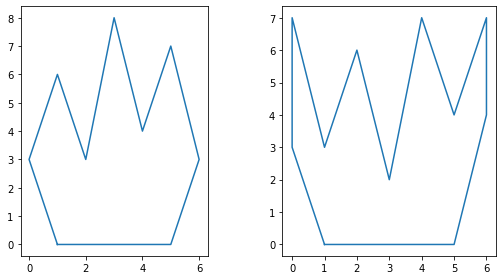

In [2]:
import matplotlib.pyplot as plt
import copy

class Polygon:
    
    def __init__(self, points):
        # List of vertices.
        self.points = copy.deepcopy(points)
        
        # Convex decomposition, computed later
        self.convex_decomposition = None
        
        # Centroid, computed later
        self.centroid = None

polygons = []

polygons.append(Polygon([
        [1, 0],
        [5, 0],
        [6, 3],
        [5, 7],
        [4, 4],
        [3, 8],
        [2, 3],
        [1, 6],
        [0, 3],
        [1, 0]]))

polygons.append(Polygon([
        [1, 0],
        [5, 0],
        [6, 4],
        [6, 7],
        [5, 4],
        [4, 7],
        [3, 2],
        [2, 6],
        [1, 3],
        [0, 7],
        [0, 3],
        [1, 0]]))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(*zip(*polygons[0].points))
axes[1].plot(*zip(*polygons[1].points))
axes[0].set_aspect('equal', adjustable='box')
axes[1].set_aspect('equal', adjustable='box')
fig.tight_layout()

## Intersection of convex polygons

if two convex polygons are disjoint, then there is an edge $e$ of one of them such that these polygons lie on the opposite sides of the line containing $e$.

Let's illustrate this property:

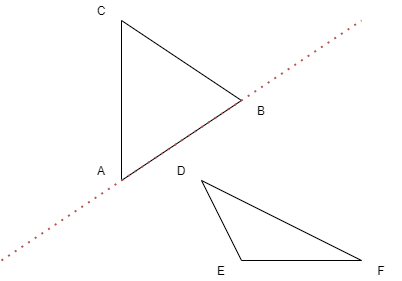

In the above example, the line (AB) is the only line generated by an edge that separates triangle (ABC) and (DEF).

Thus, to determine if two polygons intersect, we look for an edge of one of the polygons that separates them. To do so, we need to compute the relative position of a point to a line.

Relative position between point C and line (AB): 6
Relative position between point D and line (AB): -10


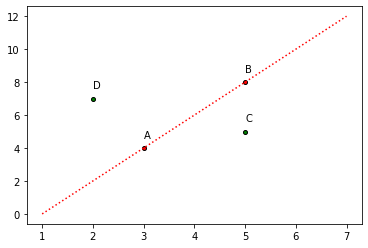

In [3]:
import numpy as np


def line_equation(point_1, point_2):
    """Get the equation of a line from two of its points.
    
    Return (a, b, c) such that:
        a * x + b * y + c >= 0
    describes all the points outside of the region defined by the line.
    """

    x1, y1 = point_1
    x2, y2 = point_2
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    return a, b, c


def relative_position(a, b, c, point):
    """Compute the relative position of a point with a line.
    
    If the returned value is positive, then the point is outside the region defined by the line.
    If the returned value is negative, then the point is inside the region defined by the line.
    If the returned value is null, then the point is on the line.
    """

    x, y = point
    return a * x + b * y + c


def distance_line_point(a, b, c, point):
    """Same as "relative_position", but return the signed distance."""

    norm = math.sqrt(a**2 + b**2)
    return distance_line_points(a, b, c, point) / norm


# To illustrate, let's consider the line defined by these two points A and B:
point_a = (3, 4)
point_b = (5, 8)

plt.plot(*point_a,
         marker="o",
         markersize=4,
         markeredgecolor="black",
         markerfacecolor="red")
plt.annotate("A",
             point_a,
             textcoords="offset points",
             xytext=(0, 10))

plt.plot(*point_b,
         marker="o",
         markersize=4,
         markeredgecolor="black",
         markerfacecolor="red")
plt.annotate("B",
             point_b,
             textcoords="offset points",
             xytext=(0, 10))

# let's compute the equation of this line.
a, b, c = line_equation(point_a, point_b)

# Plot the line (AB).
xs = [1, 7]
ys = [(-c - a * x) / b for x in xs]
plt.plot(xs, ys, linestyle="dotted", color="red")

# Now, let's consider point C, which lies outside of the region defined by line (AB).
point_c = (5, 5)

plt.plot(*point_c,
         marker="o",
         markersize=4,
         markeredgecolor="black",
         markerfacecolor="green")
plt.annotate("C",
             point_c,
             textcoords="offset points",
             xytext=(0, 10))

print("Relative position between point C and line (AB):",
      relative_position(a, b, c, point_c))

# And point D, which lies inside the region defined by line (AB).
point_d = (2, 7)

plt.plot(*point_d,
         marker="o",
         markersize=4,
         markeredgecolor="black",
         markerfacecolor="green")
plt.annotate("D",
             point_d,
             textcoords="offset points",
             xytext=(0, 10))

print("Relative position between point D and line (AB):",
      relative_position(a, b, c, point_d))

plt.show()

## Decomposition of the polygons into convex polygons

Since the intersection property only holds for convex polygons, in order to use it in our case, we need to decompose the input polygons into convex polygons first.

To decompose the input polygons into convex polygons, we use the Python library `poly_decomp`.

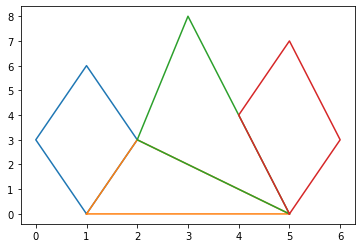

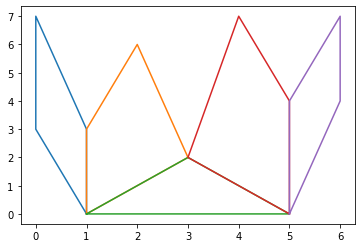

In [4]:
import poly_decomp

for polygon in polygons:
    polygon.convex_decomposition = poly_decomp.polygonDecomp(polygon.points)
    # Close the convex polygons.
    for convex_polygon in polygon.convex_decomposition:
        if convex_polygon[0] != convex_polygon[-1]:
            convex_polygon.append(convex_polygon[0])

    # Plot the convex decomposition.
    plt.figure()
    for convex_polygon in polygon.convex_decomposition:
        xs, ys = zip(*convex_polygon)
        plt.plot(xs,ys) 
    plt.show()

## Nonlinear model

**Input**
* $N$: number of polygons (here, $N = 2$).
* $K^j$: number of convex parts of polygon $P_j$.
* $L^j_k$: number of vertices of convex part $k$ of polygon $P_j$.
* $X^j_{k, l}$, $Y^j_{k, l}$: x- and y-coordinates of vertex $l$ of convex part $k$ of polygon $P_j$.



**Variables**
* $w, h \in \mathbb{R}$: width and height of the containing rectangle
* $x_j, y_j \in \mathbb{R}$, $j = 1, \dots, N$: translation vector of polygon $P_j$
* $s_j, c_j \in [-1, 1]$, $j = 1, \dots, N$: sine and cosine of the rotation angle of polygon $P_j$
* $x^j_{k, l}, y^j_{k, l} \in \mathbb{R}^+$: coordinate of vertex $l$ of convex part $k$ of polygon $P_j$
* $d^{j_1, j_2}_{k_1, l_1, k_2} \in \{ 0, 1 \}$: minimum relative position of vertices of convex part $k_2$ of polygon $P_{j_2}$ with line $(l_1, l_1 + 1)$ of convex part $k_1$ of polygon $P_1$

**Objective**: minimize the area of the containing rectangle

$$ \min w \cdot h $$

**Constraints**

* Link between $s_j$ and $c_j$

$$ \forall j = 1, 2, \qquad c_j^2 + s_j^2 = 1 $$

* Coordinates of the vertices

$$ \forall j = 1, \dots, N, \quad \forall k = 1, \dots, K_j, \quad \forall l = 1, \dots, L^j_k, \qquad x^j_{k, l} = x_j + X^j_{k, l} c_i + X^j_{k, l} s_i $$
$$ \forall j = 1, \dots, N, \quad \forall k = 1, \dots, K_j, \quad \forall l = 1, \dots, L^j_k, \qquad y^j_{k, l} = y_j + Y^j_{k, l} c_i - Y^j_{k, l} s_i $$

* Definition of $d^{j_1, j_2}_{k_1, l_1, k_2, l_2}$

$$
\forall j_1 = 1, \dots, N, \quad
\forall j_2 = 1, \dots, N, j_2 \neq j_1, \quad
\forall k_1 = 1, \dots, K_{j_1}, \quad
\forall k_2 = 1, \dots, K_{j_2}, \quad
\forall l_1 = 1, \dots, L^{j_1}_{k_1} \qquad
\forall l_1 = 2, \dots, L^{j_2}_{k_2}
$$

$$
d^{j_1, j_2}_{k_1, l_1, k_2} \le
\left( y^{j_1}_{k_1, l_1 + 1} - y^{j_1}_{k_1, l_1} \right) x^{j_2}_{k_2, l_2}
+ \left( x^{j_1}_{k_1, l_1} - x^{j_1}_{k_1, l_1 + 1} \right) y^{j_2}_{k_2, l_2}
+ x^{j_1}_{k_1, l_1 + 1} y^{j_1}_{k_1, l_1}
- x^{j_1}_{k_1, l_1} y^{j_1}_{k_1, l_1 + 1}
$$

* For each pair of polygons, each pair of convex parts from each polygon must not intersect
$$
\forall j_1 = 1, \dots, N, \quad
\forall j_2 = 1, \dots, N, j_2 \neq j_1, \quad
\forall k_1 = 1, \dots, K_{j_1}, \quad
\forall k_2 = 1, \dots, K_{j_2},
$$

$$
\max \left(
\max_{l_1 = 1, \dots, L^{j_1}_{k_1}} d^{j_1, j_2}_{k_1, l_1, k_2},
\max_{l_2 = 1, \dots, L^{j_2}_{k_2}} d^{j_2, j_1}_{k_2, l_2, k_1}
\right) \ge 0
$$

* Link between $w$ and $h$, and $x^j_{k, l}$ and $y^j_{k, l}$
$$ \forall j = 1, \dots, N, \quad \forall k = 1, \dots, K_j, \quad \forall l = 1, \dots, L^j_k, \qquad x^j_{k, l} \le w $$
$$ \forall j = 1, \dots, N, \quad \forall k = 1, \dots, K_j, \quad \forall l = 1, \dots, L^j_k, \qquad y^j_{k, l} \le h $$

Solving the nonlinear model as it is wouldn't give good results. To obtain good solutions quickly, we will
* first find a good initial point
* then solve a simplified version of the model

## Initial point

Starting from a good initial point is essential when solving packing problems with nonlinear programming.

To generate good initial points, we proceed as follows:
* We consider 8 possible rotations for both polygons
* For each pair of rotations, we place the polygons such that their centroids coincide
* We move the second polygon up until the placement becomes feasible enough

Thus we get 64 near feasible initial points.

c1 1 s1 0 c2 1 s2 0


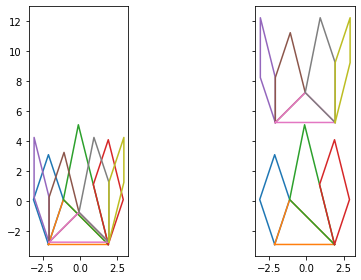

c1 1 s1 0 c2 0.7071067811865476 s2 0.7071067811865476


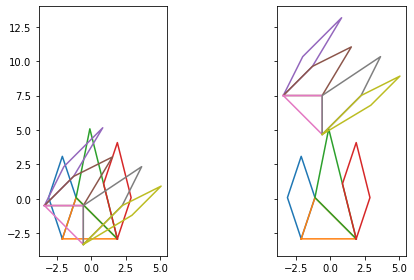

c1 1 s1 0 c2 0 s2 1


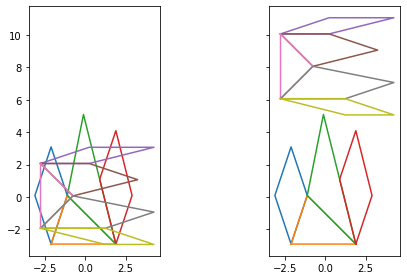

c1 1 s1 0 c2 -0.7071067811865476 s2 0.7071067811865476


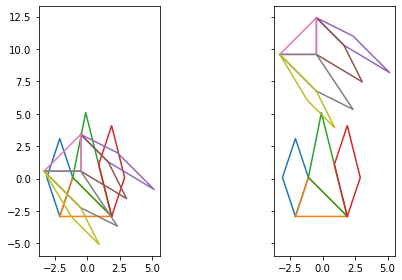

c1 1 s1 0 c2 -1 s2 0


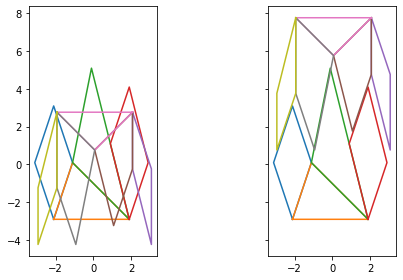

c1 1 s1 0 c2 -0.7071067811865476 s2 -0.7071067811865476


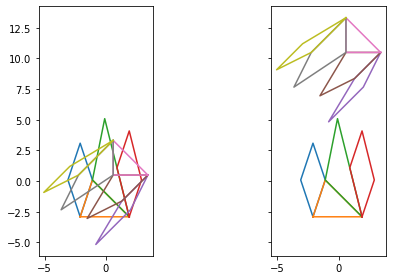

c1 1 s1 0 c2 0 s2 -1


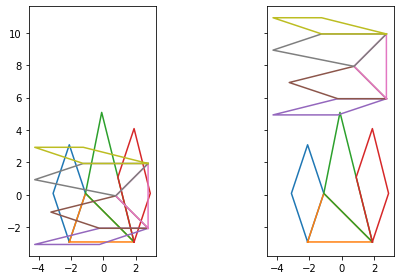

c1 1 s1 0 c2 0.7071067811865476 s2 -0.7071067811865476


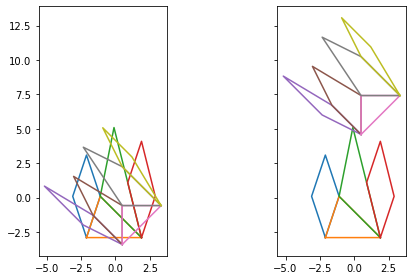

c1 0.7071067811865476 s1 0.7071067811865476 c2 1 s2 0


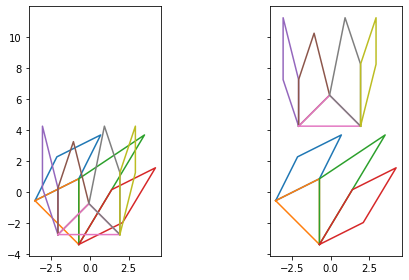

c1 0.7071067811865476 s1 0.7071067811865476 c2 0.7071067811865476 s2 0.7071067811865476


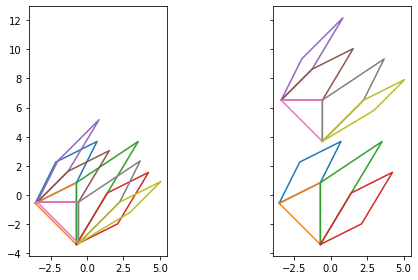

c1 0.7071067811865476 s1 0.7071067811865476 c2 0 s2 1


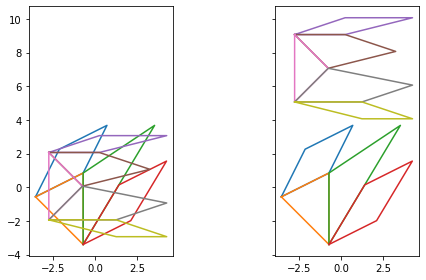

c1 0.7071067811865476 s1 0.7071067811865476 c2 -0.7071067811865476 s2 0.7071067811865476


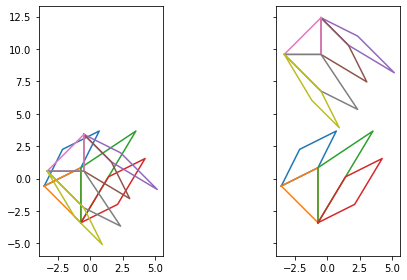

c1 0.7071067811865476 s1 0.7071067811865476 c2 -1 s2 0


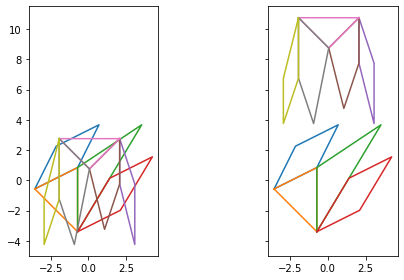

c1 0.7071067811865476 s1 0.7071067811865476 c2 -0.7071067811865476 s2 -0.7071067811865476


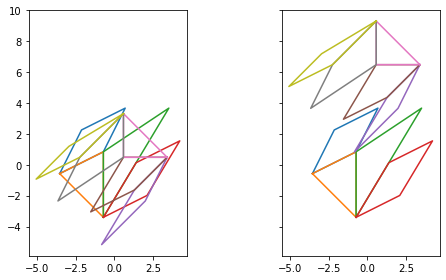

c1 0.7071067811865476 s1 0.7071067811865476 c2 0 s2 -1


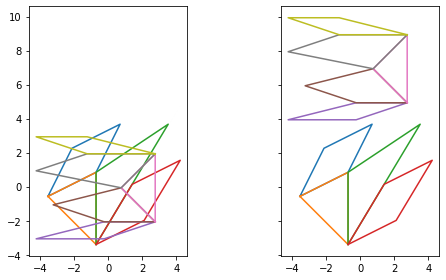

c1 0.7071067811865476 s1 0.7071067811865476 c2 0.7071067811865476 s2 -0.7071067811865476


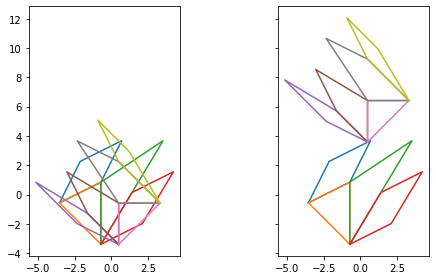

c1 0 s1 1 c2 1 s2 0


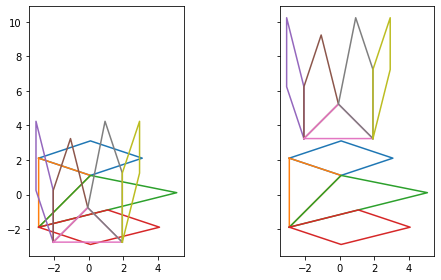

c1 0 s1 1 c2 0.7071067811865476 s2 0.7071067811865476


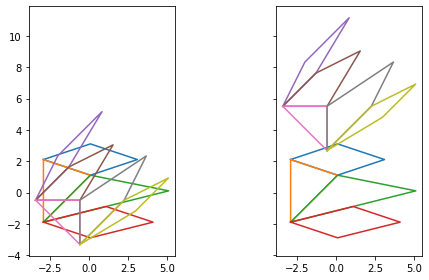

c1 0 s1 1 c2 0 s2 1


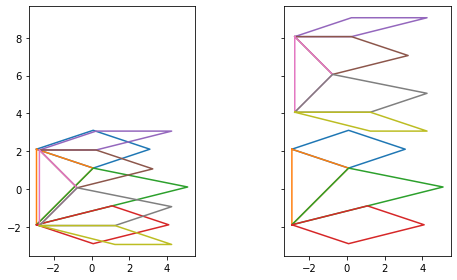

c1 0 s1 1 c2 -0.7071067811865476 s2 0.7071067811865476


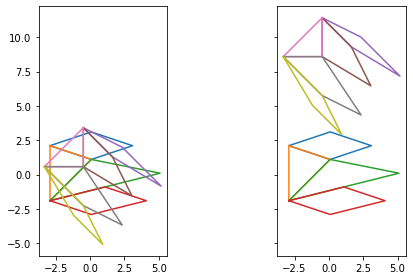

c1 0 s1 1 c2 -1 s2 0


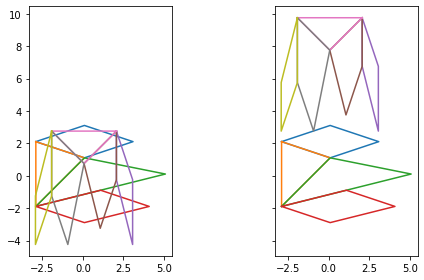

c1 0 s1 1 c2 -0.7071067811865476 s2 -0.7071067811865476


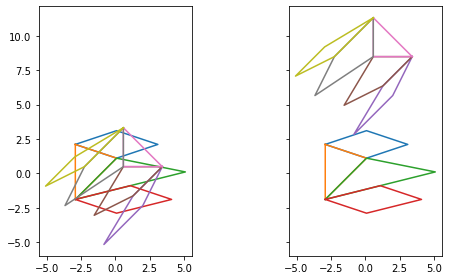

c1 0 s1 1 c2 0 s2 -1


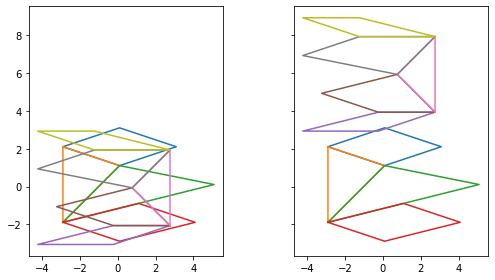

c1 0 s1 1 c2 0.7071067811865476 s2 -0.7071067811865476


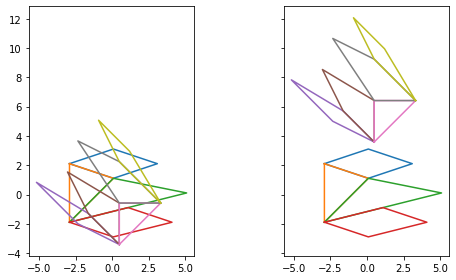

c1 -0.7071067811865476 s1 0.7071067811865476 c2 1 s2 0


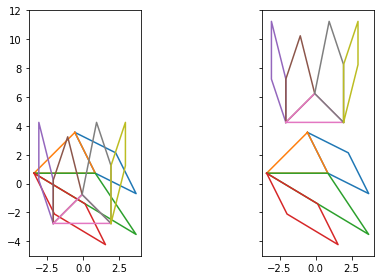

c1 -0.7071067811865476 s1 0.7071067811865476 c2 0.7071067811865476 s2 0.7071067811865476


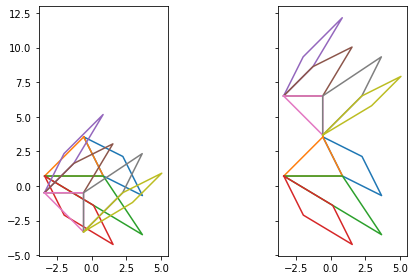

c1 -0.7071067811865476 s1 0.7071067811865476 c2 0 s2 1


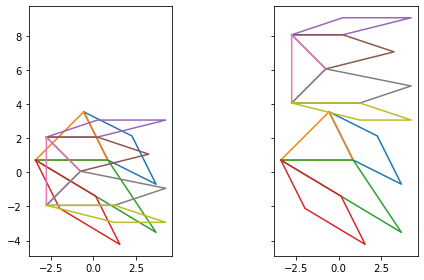

c1 -0.7071067811865476 s1 0.7071067811865476 c2 -0.7071067811865476 s2 0.7071067811865476


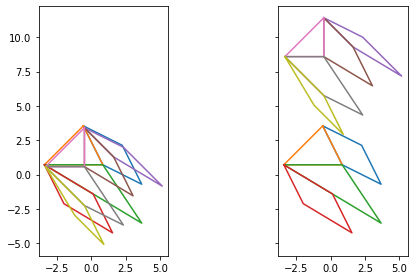

c1 -0.7071067811865476 s1 0.7071067811865476 c2 -1 s2 0


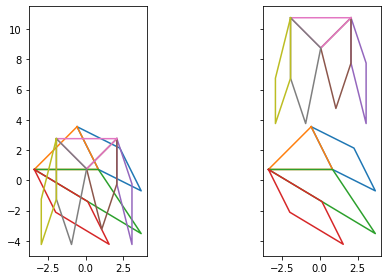

c1 -0.7071067811865476 s1 0.7071067811865476 c2 -0.7071067811865476 s2 -0.7071067811865476


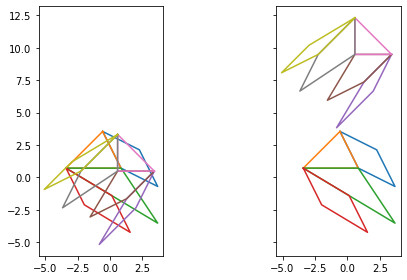

c1 -0.7071067811865476 s1 0.7071067811865476 c2 0 s2 -1


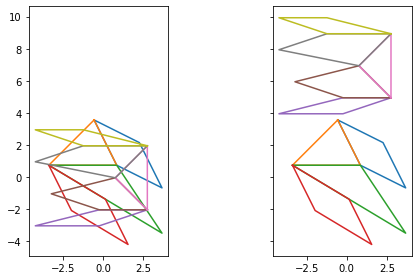

c1 -0.7071067811865476 s1 0.7071067811865476 c2 0.7071067811865476 s2 -0.7071067811865476


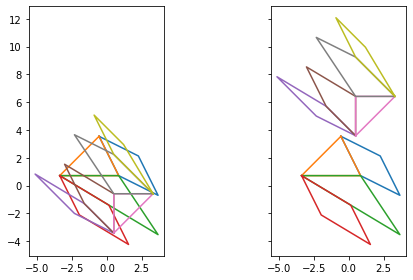

c1 -1 s1 0 c2 1 s2 0


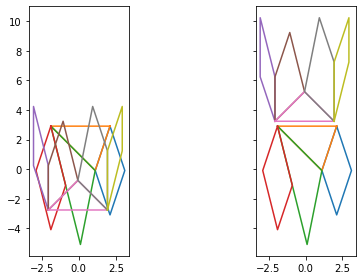

c1 -1 s1 0 c2 0.7071067811865476 s2 0.7071067811865476


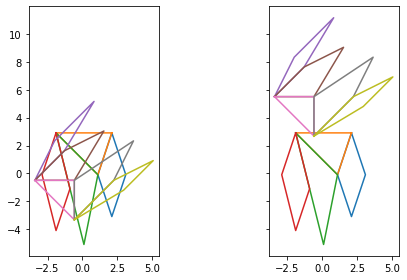

c1 -1 s1 0 c2 0 s2 1


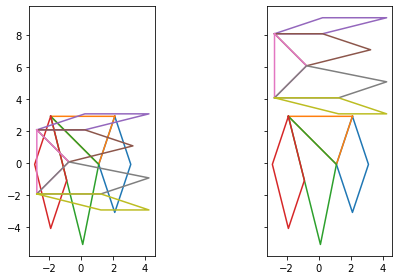

c1 -1 s1 0 c2 -0.7071067811865476 s2 0.7071067811865476


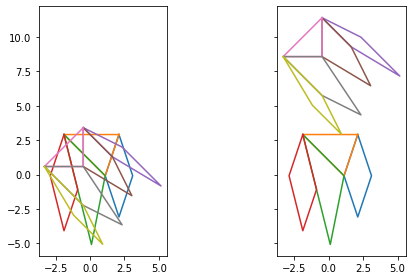

c1 -1 s1 0 c2 -1 s2 0


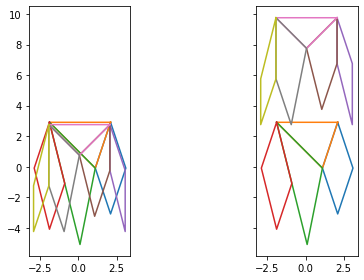

c1 -1 s1 0 c2 -0.7071067811865476 s2 -0.7071067811865476


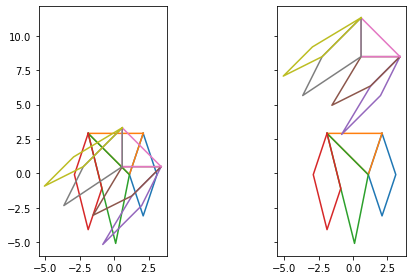

c1 -1 s1 0 c2 0 s2 -1


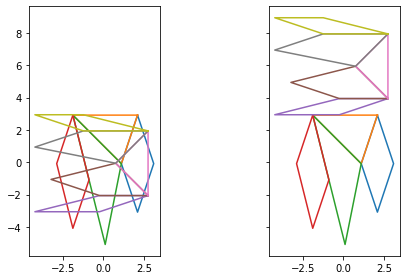

c1 -1 s1 0 c2 0.7071067811865476 s2 -0.7071067811865476


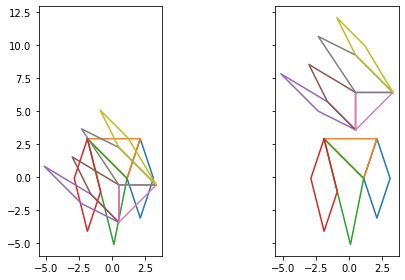

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 1 s2 0


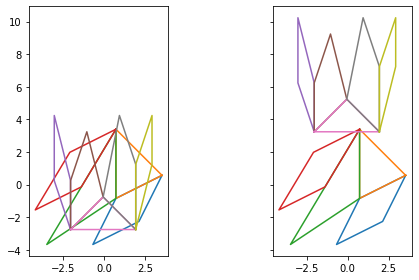

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 0.7071067811865476 s2 0.7071067811865476


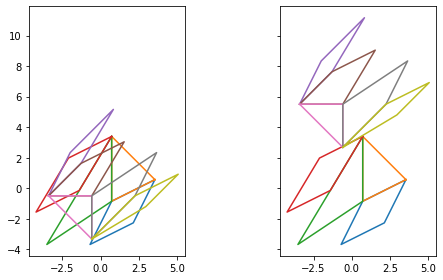

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 0 s2 1


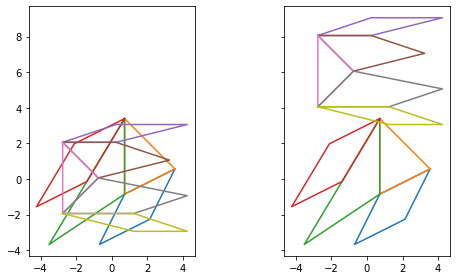

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 -0.7071067811865476 s2 0.7071067811865476


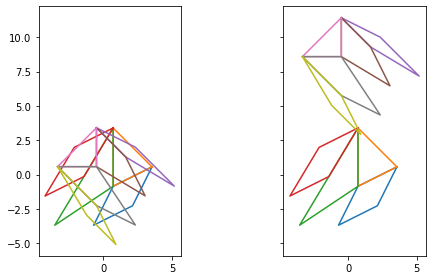

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 -1 s2 0


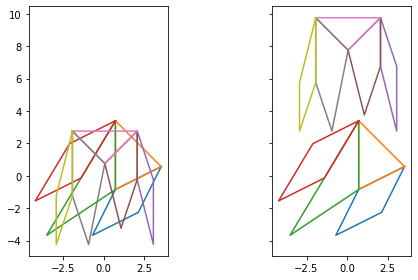

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 -0.7071067811865476 s2 -0.7071067811865476


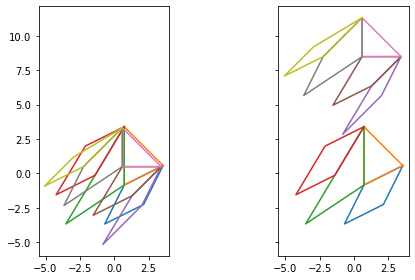

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 0 s2 -1


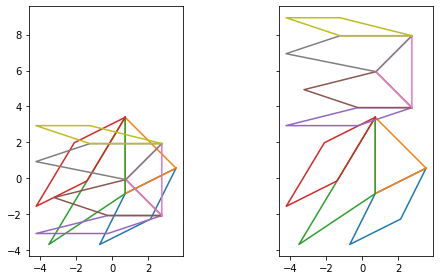

c1 -0.7071067811865476 s1 -0.7071067811865476 c2 0.7071067811865476 s2 -0.7071067811865476


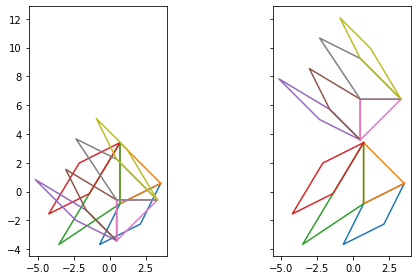

c1 0 s1 -1 c2 1 s2 0


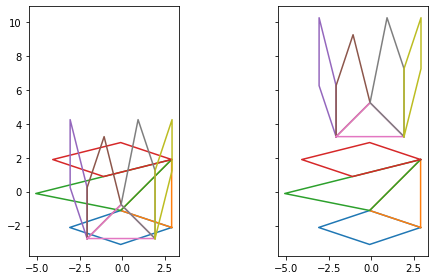

c1 0 s1 -1 c2 0.7071067811865476 s2 0.7071067811865476


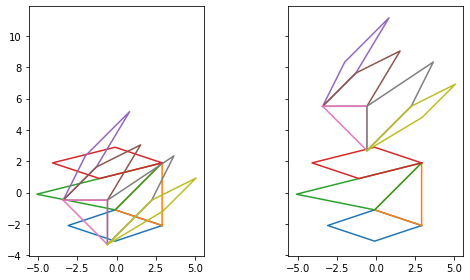

c1 0 s1 -1 c2 0 s2 1


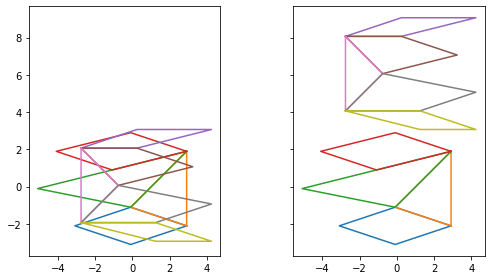

c1 0 s1 -1 c2 -0.7071067811865476 s2 0.7071067811865476


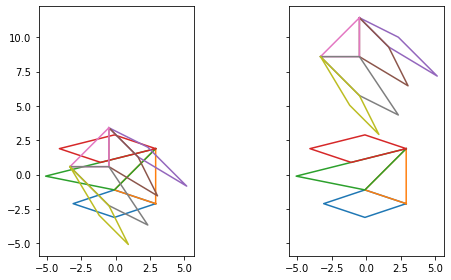

c1 0 s1 -1 c2 -1 s2 0


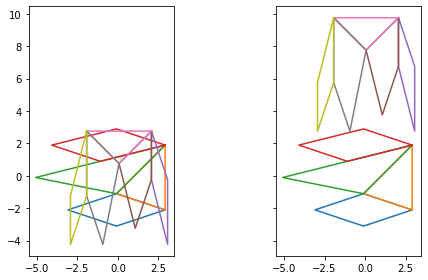

c1 0 s1 -1 c2 -0.7071067811865476 s2 -0.7071067811865476


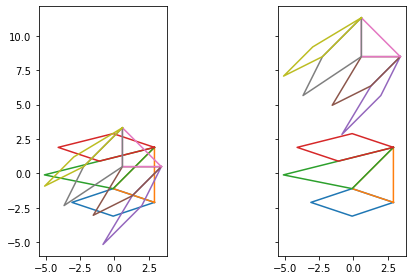

c1 0 s1 -1 c2 0 s2 -1


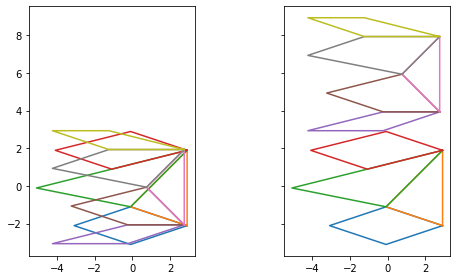

c1 0 s1 -1 c2 0.7071067811865476 s2 -0.7071067811865476


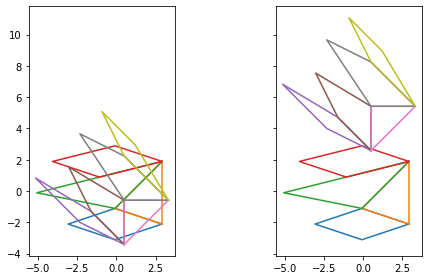

c1 0.7071067811865476 s1 -0.7071067811865476 c2 1 s2 0


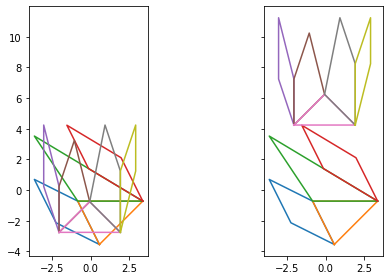

c1 0.7071067811865476 s1 -0.7071067811865476 c2 0.7071067811865476 s2 0.7071067811865476


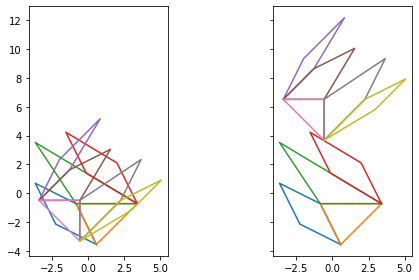

c1 0.7071067811865476 s1 -0.7071067811865476 c2 0 s2 1


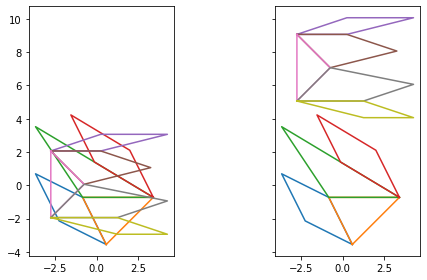

c1 0.7071067811865476 s1 -0.7071067811865476 c2 -0.7071067811865476 s2 0.7071067811865476


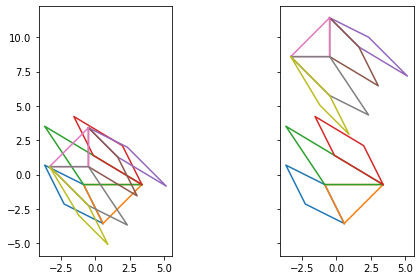

c1 0.7071067811865476 s1 -0.7071067811865476 c2 -1 s2 0


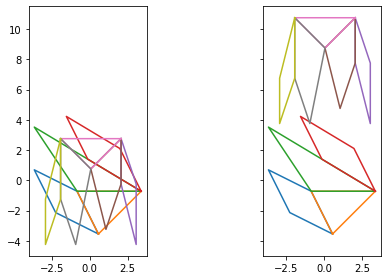

c1 0.7071067811865476 s1 -0.7071067811865476 c2 -0.7071067811865476 s2 -0.7071067811865476


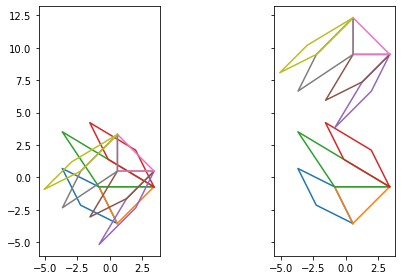

c1 0.7071067811865476 s1 -0.7071067811865476 c2 0 s2 -1


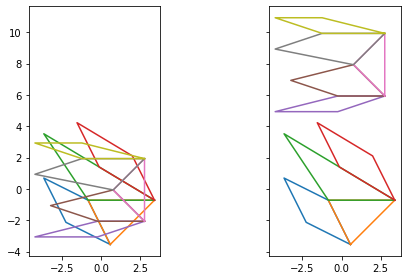

c1 0.7071067811865476 s1 -0.7071067811865476 c2 0.7071067811865476 s2 -0.7071067811865476


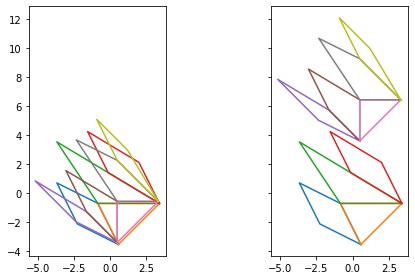

Best initial point:


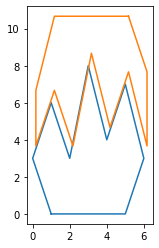

In [5]:
import shapely.geometry
import math


def rotate(x, y, cos_theta, sin_theta):
    """Get the coordinates of a point after a rotation."""
    return (cos_theta * x + sin_theta * y,
            cos_theta * y - sin_theta * x)


def compute_feasibility_error_convex_polygon(
        convex_polygon_1,
        convex_polygon_2):

    feasibility_error = 0
    value_best = None
    l1_best = None
    l2_best = None
    for l1, v1 in enumerate(convex_polygon_1[:-1]):
        value = float('inf')  # Minimum relative distance between (v1, v1p1) and each vertex v2
        v1p1 = convex_polygon_1[l1 + 1]
        a, b, c = line_equation(v1, v1p1)
        for l2, v2 in enumerate(convex_polygon_2[:-1]):
            value = min(value, relative_position(a, b, c, v2))
        # print("l1", l1, "v1", v1, "v1p1", v1p1, "value", value)
        if value_best is None or value_best < value:
            value_best = value
            l1_best = l1
            l2_best = None
    for l2, v2 in enumerate(convex_polygon_2[:-1]):
        value = float('inf')
        v2p2 = convex_polygon_2[l2 + 1]
        a, b, c = line_equation(v2, v2p2)
        for l1, v1 in enumerate(convex_polygon_1[:-1]):
            value = min(value, relative_position(a, b, c, v1))
        # print("l2", l2, "v2", v2, "v2p2", v2p2, "value", value)
        if value_best is None or value_best < value:
            value_best = value
            l1_best = None
            l2_best = l2
    feasibility_error = -value_best
    return feasibility_error, l1_best, l2_best


def compute_feasibility_error(
        polygon_1_convex_decomposition,
        polygon_2_convex_decomposition):
    
    feasibility_error = 0.0
    intersection_constraints = []
    for k1, convex_polygon_1 in enumerate(polygon_1_convex_decomposition):
        for k2, convex_polygon_2 in enumerate(polygon_2_convex_decomposition):
            feasibility_error_cur, l1, l2 = compute_feasibility_error_convex_polygon(
                    convex_polygon_1,
                    convex_polygon_2)
            # print("k1", k1, "k2", k2, "l1", l1, "l2", l2, "feasibility_error", feasibility_error_cur)
            feasibility_error = max(feasibility_error, feasibility_error_cur)
            # Store the intersection constraint.
            intersection_constraints.append((k1, k2, l1, l2))
    return feasibility_error, intersection_constraints


def plot_solution(x, y, c, s):
    # print("plot_solution")
    # print("x", x)
    # print("y", y)
    # print("c", c)
    # print("s", s)
    # print(polygon_1)

    plt.figure()
    for j, polygon in enumerate(polygons):
        p = [rotate(x, y, c[j], s[j]) for x, y in polygon.points]
        xs = [x[j] + xv for xv, yv in p]
        ys = [y[j] + yv for xv, yv in p]
        plt.plot(xs, ys) 
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()


class InitialPoint:
    
    def __init__(self, c, s, x, y, w, h, intersection_constraints):
        self.c = c
        self.s = s
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.intersection_constraints = []
        for k1, k2, l1, l2 in intersection_constraints:
            if l1 is not None:
                self.intersection_constraints.append((0, k1, l1, 1, k2))
            else:
                self.intersection_constraints.append((1, k2, l2, 0, k1))


for polygon in polygons:
    shapely_polygon = shapely.geometry.Polygon(polygon.points)
    polygon.centroid = (shapely_polygon.centroid.x, shapely_polygon.centroid.y)
    # print(polygon.centroid)

initial_points = []
f = math.sqrt(0.5)
# For each of the 8 rotations of the first polygon.
for c1, s1 in [(1, 0), (f, f), (0, 1), (-f, f), (-1, 0), (-f, -f), (0, -1), (f, -f)]:
    # Compute the rotated centroid of the polygon.
    xc1, yc1 = rotate(*polygons[0].centroid, c1, s1)
    # Rotate the convex polygons of its convex decompositions.
    polygon_1_convex_decomposition = [[rotate(x, y, c1, s1)
                                       for x, y in convex_polygon]
                                      for convex_polygon in polygons[0].convex_decomposition]
    # And translate them such that the centroid moves at (0, 0).
    polygon_1_convex_decomposition = [[(x - xc1, y - yc1)
                                       for x, y in convex_polygon]
                                      for convex_polygon in polygon_1_convex_decomposition]
    
    # For each of the 8 rotations of the second polygon.
    for c2, s2 in [(1, 0), (f, f), (0, 1), (-f, f), (-1, 0), (-f, -f), (0, -1), (f, -f)]:
        print("c1", c1, "s1", s1, "c2", c2, "s2", s2)
        
        # if c1 != 0 or s1 != 1 or c2 != 0 or s2 != -1:
        #     continue

        # Compute the rotated centroid of the polygon.
        xc2, yc2 = rotate(*polygons[1].centroid, c2, s2)
        # Rotate the convex polygons of its convex decompositions.
        polygon_2_convex_decomposition = [[rotate(x, y, c2, s2)
                                           for x, y in convex_polygon]
                                          for convex_polygon in polygons[1].convex_decomposition]
        # And translate them such that the centroid moves at (0, 0).
        polygon_2_convex_decomposition = [[(x - xc2, y - yc2)
                                           for x, y in convex_polygon]
                                          for convex_polygon in polygon_2_convex_decomposition]

        # Let's plot the current configuration.
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey='row')
        for convex_polygon in polygon_1_convex_decomposition:
            axes[0].plot(*zip(*convex_polygon)) 
        for convex_polygon in polygon_2_convex_decomposition:
            axes[0].plot(*zip(*convex_polygon))
        axes[0].set_aspect('equal', adjustable='box')
        
        # Now, we move the second polygon upward unitil the two polygons don't intersect too much.
        y_offset = 0
        while True:
            # print("y_offset", y_offset)

            # Translate the convex polygons of the second polygon.
            polygon_2_convex_decomposition_offset = [
                    [(x, y + y_offset)
                     for x, y in convex_polygon]
                    for convex_polygon in polygon_2_convex_decomposition]
            
            if y_offset > 10:
                plt.figure()
                for convex_polygon in polygon_1_convex_decomposition:
                    plt.plot(*zip(*convex_polygon)) 
                for convex_polygon in polygon_2_convex_decomposition_offset:
                    plt.plot(*zip(*convex_polygon)) 
                plt.show()
            
            # Compute the feasibility error.
            feasibility_error, intersection_constraints = compute_feasibility_error(
                    polygon_1_convex_decomposition,
                    polygon_2_convex_decomposition_offset)
            # print("feasibility_error", feasibility_error)

            if feasibility_error < 1:
                # If it is feasible enough, store the point and stop here.
                for convex_polygon in polygon_1_convex_decomposition:
                    axes[1].plot(*zip(*convex_polygon)) 
                for convex_polygon in polygon_2_convex_decomposition_offset:
                    axes[1].plot(*zip(*convex_polygon))   
                axes[1].set_aspect('equal', adjustable='box')
                fig.tight_layout()
                plt.show()
                
                x_min = min(
                    min(x for convex_polygon in polygon_1_convex_decomposition for x, y in convex_polygon),
                    min(x for convex_polygon in polygon_2_convex_decomposition_offset for x, y in convex_polygon))
                y_min = min(
                    min(y for convex_polygon in polygon_1_convex_decomposition for x, y in convex_polygon),
                    min(y for convex_polygon in polygon_2_convex_decomposition_offset for x, y in convex_polygon))                
                x_max = max(
                    max(x for convex_polygon in polygon_1_convex_decomposition for x, y in convex_polygon),
                    max(x for convex_polygon in polygon_2_convex_decomposition_offset for x, y in convex_polygon))
                y_max = max(
                    max(y for convex_polygon in polygon_1_convex_decomposition for x, y in convex_polygon),
                    max(y for convex_polygon in polygon_2_convex_decomposition_offset for x, y in convex_polygon))
                
                initial_point = InitialPoint(
                        (c1, c2),
                        (s1, s2),
                        (- xc1 - x_min, - xc2 - x_min),
                        (- yc1 - y_min, - yc2 + y_offset - y_min),
                        x_max - x_min,
                        y_max - y_min,
                        intersection_constraints)

                # plot_solution(initial_point.x,
                #               initial_point.y,
                #               initial_point.c,
                #               initial_point.s)

                initial_points.append(initial_point)
                break
            else:
                # Otherwise, increase the offset.
                y_offset += 1

# Sort the intial points by area.
initial_points.sort(key=lambda initial_point: initial_point.width * initial_point.height)

print("Best initial point:")
plot_solution(initial_points[0].x,
              initial_points[0].y,
              initial_points[0].c,
              initial_points[0].s)

The initial point strategy returns a point which looks very promising. However:
* It is slightly infeasible
* The polygons do not fit perfectly together

The goal of the nonlinear programming step is to fix this.

## Simplified nonlinear model

To simplify the model, for each pair of convex polygons from different polygons, we will fix in advance which edge from these convex polygons is responsible for the non-intersection of the convex polygons.

That is, we replace these constraints

$$
\forall j_1 = 1, \dots, N, \quad
\forall j_2 = 1, \dots, N, j_2 \neq j_1, \quad
\forall k_1 = 1, \dots, K_{j_1}, \quad
\forall k_2 = 1, \dots, K_{j_2}, \quad
\forall l_1 = 1, \dots, L^{j_1}_{k_1} \qquad
\forall l_1 = 1, \dots, L^{j_2}_{k_2}
$$

$$
d^{j_1, j_2}_{k_1, l_1, k_2} \le
\left( y^{j_1}_{k_1, l_1 + 1} - y^{j_1}_{k_1, l_1} \right) x^{j_2}_{k_2, l_2}
+ \left( x^{j_1}_{k_1, l_1} - x^{j_1}_{k_1, l_1 + 1} \right) y^{j_2}_{k_2, l_2}
+ x^{j_1}_{k_1, l_1 + 1} y^{j_1}_{k_1, l_1}
- x^{j_1}_{k_1, l_1} y^{j_1}_{k_1, l_1 + 1}
$$

and

$$
\forall j_1 = 1, \dots, N, \quad
\forall j_2 = 1, \dots, N, j_2 \neq j_1, \quad
\forall k_1 = 1, \dots, K_{j_1}, \quad
\forall k_2 = 1, \dots, K_{j_2},
$$

$$
\max \left(
\max_{l_1 = 1, \dots, L^{j_1}_{k_1}} d^{j_1, j_2}_{k_1, l_1, k_2},
\max_{l_2 = 1, \dots, L^{j_2}_{k_2}} d^{j_2, j_1}_{k_2, l_2, k_1}
\right) \ge 0
$$

by:

$$
\forall j_1 = 1, \dots, N, \quad
\forall j_2 = j_1 + 1, \dots, N,
\forall k_1 = 1, \dots, K_{j_1}, \quad
\forall k_2 = 1, \dots, K_{j_2},
$$

If the edge chosen to separate convex part $k_1$ of polygon $P_{j_1}$ and convex part $k_2$ of polygon $P_{j_2}$ is edge $(l_1, l_1 + 1)$ from convex part $k_1$ of polygon $P_{j_1}$:

$$
\forall l_2 = 1, \dots, L^{j_2}_{k_2} \qquad
\left( y^{j_1}_{k_1, l_1 + 1} - y^{j_1}_{k_1, l_1} \right) x^{j_2}_{k_2, l_2}
+ \left( x^{j_1}_{k_1, l_1} - x^{j_1}_{k_1, l_1 + 1} \right) y^{j_2}_{k_2, l_2}
+ x^{j_1}_{k_1, l_1 + 1} y^{j_1}_{k_1, l_1}
- x^{j_1}_{k_1, l_1} y^{j_1}_{k_1, l_1 + 1}
\ge 0
$$

Otherwise, if the edge chosen to separate convex part $k_1$ of polygon $P_{j_1}$ and convex part $k_2$ of polygon $P_{j_2}$ is edge $(l_2, l_2 + 1)$ from convex part $k_2$ of polygon $P_{j_2}$:

$$
\forall l_1 = 1, \dots, L^{j_1}_{k_1} \qquad
\left( y^{j_2}_{k_2, l_2 + 1} - y^{j_2}_{k_2, l_2} \right) x^{j_1}_{k_1, l_1}
+ \left( x^{j_2}_{k_2, l_2} - x^{j_2}_{k_2, l_2 + 1} \right) y^{j_1}_{k_1, l_1}
+ x^{j_2}_{k_2, l_2 + 1} y^{j_2}_{k_2, l_2}
- x^{j_2}_{k_2, l_2} y^{j_2}_{k_2, l_2 + 1}
\ge 0
$$

Variables $d^{j_1, j_2}_{k_1, l_1, k_2}$ are not necessary anymore.

## Pyomo model

Now, let's write the model with Pyomo.

Initial point:


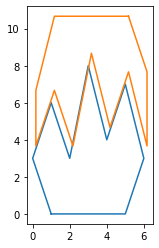

Artelys Knitro 14.1.0: 
          Commercial License
         Artelys Knitro 14.1.0

Knitro presolve eliminated 0 variables and 0 constraints.

concurrent_evals         0
datacheck                0
hessian_no_f             1
hessopt                  1
The problem is identified as a QCQP.

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Minimize
Objective type:  quadratic
Number of variables:                                 78 (          78)
    bounded below only:                              70 (          70)
    bounded above only:                               0 (           0)
    bounded below and above:                          4 (           4)
    fixed:                                            0 (           0)
    free:                                             4 (           4)
Number of constraints:                              216 (         216)
    linear equalities:                               68 (        

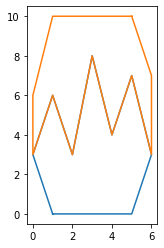

In [6]:
import pyomo.environ as pyo
import math
import logging

#logging.getLogger('pyomo.core').setLevel(logging.ERROR)
    

nkl = [(j, k, l)
       for j, polygon in enumerate(polygons)
       for k, convex_polygon in enumerate(polygon.convex_decomposition)
       for l, vertex in enumerate(convex_polygon[:-1])]


def solve_model(initial_point):

    # print("x_init", initial_point.x)
    # print("y_init", initial_point.y)
    # print("c_init", initial_point.c)
    # print("s_init", initial_point.s)

    # Create a model
    model = pyo.ConcreteModel()

    ####################
    # Create variables #
    ####################

    model.N = pyo.RangeSet(0, 1)

    model.NKL = pyo.RangeSet(0, len(nkl) - 1)

    intersection_constraints_list = [(j1, k1, l1, j2, k2, l2)
                                     for j1, k1, l1, j2, k2 in initial_point.intersection_constraints
                                     for l2 in range(len(polygons[j2].convex_decomposition[k2]) - 1)]
    model.I = pyo.RangeSet(0, len(intersection_constraints_list) - 1)

    # Variables w and h
    model.w = pyo.Var(within=pyo.NonNegativeReals)
    model.h = pyo.Var(within=pyo.NonNegativeReals)

    # Variables x_j and y_j.
    model.x = pyo.Var(model.N, within=pyo.Reals)
    model.y = pyo.Var(model.N, within=pyo.Reals)

    # Variables cj and sj.
    model.c = pyo.Var(model.N, within=pyo.Reals, bounds=(-1, 1))
    model.s = pyo.Var(model.N, within=pyo.Reals, bounds=(-1, 1))

    # Variables x^j_{k, l} and y^j_{k, l}
    model.xv = pyo.Var(model.NKL, within=pyo.NonNegativeReals)
    model.yv = pyo.Var(model.NKL, within=pyo.NonNegativeReals)

    for j, polygon in enumerate(polygons):
        model.x[j] = initial_point.x[j]
        model.y[j] = initial_point.y[j]
        model.c[j] = initial_point.c[j]
        model.s[j] = initial_point.s[j]
    for jkl in model.NKL:
        j, k, l = nkl[jkl]
        xv = (initial_point.x[j]
              + polygons[j].convex_decomposition[k][l][0] * initial_point.c[j]
              + polygons[j].convex_decomposition[k][l][1] * initial_point.s[j])
        yv = (initial_point.y[j]
              + polygons[j].convex_decomposition[k][l][1] * initial_point.c[j]
              - polygons[j].convex_decomposition[k][l][0] * initial_point.s[j])
        # print("j", j, "k", k, "l", l,
        #       "x_init", x_init[j], "xo", polygons[j][k][l][0], "xv", xv,
        #       "y_init", y_init[j], "yo", polygons[j][k][l][1], "yv", yv)
        model.xv[jkl] = xv
        model.yv[jkl] = yv
    model.w = initial_point.width
    model.h = initial_point.height
    
    #############
    # Objective #
    #############

    # min w * h
    def objective_rule(model):
        return (model.w * model.h)
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    ###############
    # Constraints #
    ###############

    # Constraints: link between cj and sj.
    # For all j = 1..N, cj^2 + sj^2 = 1
    def link_cj_sj(model, j):
        return model.c[j] * model.c[j] + model.s[j] * model.s[j] == 1
    model.constraints_link_cj_sj = pyo.Constraint(model.N, rule=link_cj_sj)

    # Constraints: x-coordinates of the vertices
    # For all j = 1..N, For all k = 1..K_j, For all l = 1..L^j_k
    # x^j_{k, l} = x_j + X^j_{k, l} c_i + Y^j_{k, l} s_i
    def vertex_x_coordinate(model, jkl):
        j, k, l = nkl[jkl]
        return (model.xv[jkl]
                == model.x[j]
                + polygons[j].convex_decomposition[k][l][0] * model.c[j]
                + polygons[j].convex_decomposition[k][l][1] * model.s[j])
    model.constraints_vertex_x_coordinate = pyo.Constraint(model.NKL, rule=vertex_x_coordinate)

    # Constraints: y-coordinates of the vertices
    # For all j = 1..N, For all k = 1..K_j, For all l = 1..L^j_k
    # y^j_{k, l} = y_j + Y^j_{k, l} c_i - X^j_{k, l} s_i
    def vertex_y_coordinate(model, jkl):
        j, k, l = nkl[jkl]
        return (model.yv[jkl]
                == model.y[j]
                + polygons[j].convex_decomposition[k][l][1] * model.c[j]
                - polygons[j].convex_decomposition[k][l][0] * model.s[j])
    model.constraints_vertex_y_coordinate = pyo.Constraint(model.NKL, rule=vertex_y_coordinate)

    # Constraints: intersections
    # ( x^{j_1}_{k_1, l_1} - x^{j_1}_{k_1, l_1 + 1} ) ( y^{j_1}_{k_1, l_1} - y^{j_2}_{k_2, l_2} )
    #     - ( y^{j_1}_{k_1, l_1} - y^{j_1}_{k_1, l_1 + 1} ) ( x^{j_1}_{k_1, l_1} - x^{j_2}_{k_2, l_2} )
    #     <= 0
    nkl_to_id = {}
    for index, jkl in enumerate(nkl):
        nkl_to_id[jkl] = index
    def intersections(model, j1k1l1j2k2l2):
        j1, k1, l1, j2, k2, l2 = intersection_constraints_list[j1k1l1j2k2l2]
        l1p1 = (l1 + 1) % (len(polygons[j1].convex_decomposition[k1]) - 1)
        j1k1l1 = nkl_to_id[(j1, k1, l1)]
        j1k1l1p1 = nkl_to_id[(j1, k1, l1p1)]
        j2k2l2 = nkl_to_id[(j2, k2, l2)]
        return ((model.xv[j1k1l1] - model.xv[j1k1l1p1])
                * (model.yv[j1k1l1] - model.yv[j2k2l2])
                - (model.yv[j1k1l1] - model.yv[j1k1l1p1])
                * (model.xv[j1k1l1] - model.xv[j2k2l2])
                <= 0)
    model.constraints_intersections = pyo.Constraint(model.I, rule=intersections)

    # Constraints: width
    # For all j = 1..N, for all k = 1..K_j, for all l = 1..L^j_k, x^j_{k, l} <= w
    def width(model, jkl):
        return model.xv[jkl] <= model.w
    model.constraints_width = pyo.Constraint(model.NKL, rule=width)

    # Constraints: height
    # For all j = 1..N, for all k = 1..K_j, for all l = 1..L^j_k, y^j_{k, l} <= h
    def height(model, jkl):
        return model.yv[jkl] <= model.h
    model.constraints_height = pyo.Constraint(model.NKL, rule=height)

    #model.pprint()
    #model.write("model.nl")

    #########
    # Solve #
    #########

    # Solve with Knitro.
    solver = pyo.SolverFactory('knitroampl')
    #solver.options["numthreads"] = 8
    results = solver.solve(model, tee=True)
    
    return ([model.x[i]() for i in range(len(polygons))],
            [model.y[i]() for i in range(len(polygons))],
            [model.c[i]() for i in range(len(polygons))],
            [model.s[i]() for i in range(len(polygons))],
            model.w(),
            model.h())

initial_point = initial_points[0]

print("Initial point:")
plot_solution(initial_point.x,
              initial_point.y,
              initial_point.c,
              initial_point.s)

x, y, c, s, w, h = solve_model(initial_point)

# print("x", x)
# print("y", y)
# print("c", c)
# print("s", s)
# print("w", w)
# print("h", h)

print("Final solution")
plot_solution(x, y, c, s)